##Análise dos dados sobre educação superior do inep. Dados foram retirados [aqui](https://drive.google.com/file/d/1--ZZX9OJ-HDAJ7S3IPVTS5N3eZ7C0i5q/view?usp=sharing) e foram gerados utilizando este [notebook](https://colab.research.google.com/drive/18e-uYMOlBzwcCpCAIVJN4xmw37e1tVOM?usp=sharing)


#Instalando e importanto bibliotecas  

In [16]:
!pip install dask[dataframe]

In [17]:
import pandas as pd
import requests, zipfile, io
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Extraindo os dados

Utilizando um snippet do stackoverflow, podemos pegar os dados do google drive armazenado. Vamos utilizar este código. Vamos criar um arquivo chamado data.csv onde iremos armazenar esta informação e posteriormente carregar os dados na variável data.

In [18]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [19]:
file_id = "1--ZZX9OJ-HDAJ7S3IPVTS5N3eZ7C0i5q"

!touch data.csv
destination = '/content/data.csv'
download_file_from_google_drive(file_id, destination)
data = dd.read_csv(destination ,encoding = "ISO-8859-1",dtype={'CO_ALUNO': 'object'})
print("Dados carregados com sucesso em um dask dataframe")
data = data.compute()
print("Dados carregados com sucesso em um pandas dataframe")

Dados carregados com sucesso em um dask dataframe
Dados carregados com sucesso em um pandas dataframe


In [20]:
data.columns

Index(['Cat_Adm', 'Nivel_Aca', 'Cor/Raca', 'Genero', 'Cota_Racial',
       'Apoio_Social', 'Ano', 'Nome_Curso', 'Nome_Instituição', 'Municipio',
       'UF', 'CAPITAL'],
      dtype='object')

As colunas indicam as  seguintes informações :



* Cat_Adm = Categoria Administrativa do IES que o aluno esta matriculado.

* Nivel_Aca = Nivél Acadêmico do Aluno( Graduaçao, Curso Especial)

* Cor/Raca = Cor/Raça a qual o aluno se identifica

* Genero = Genero que o aluno se identifica

* Cota_Racial = Indica se o aluno ingressou na faculdade por meio de cotas de cunho etnico

* Apoio_Social = Indica se o aluno recebeu algum apoio de cunho social.

* Ano = Ano que o dado foi coletado.

* Nome_Curso = Nome do curso onde o Aluno esta matriculado

* Nome_Instituição =Nome da Instituição de ensino onde o Aluno esta matriculado
 
* Municipio = Nome do Municipio onde a IES está localizada

* UF = Nome da UF onde a IES está localizada

* CAPITAL = Infomra se a IES esta localizada em uma capital(1-Sim, 0 - Não)

#Análise

##Análise geral de alunos

Vamos ter uma visão geral dos dados por ano, isto é, quantos alunos novos foram matriculados por ano no curso superior.

In [21]:
  data_estudantes= data.Ano.value_counts()
  serie_estudantes = data_estudantes.sort_index(ascending= True).values
  anos =list(range(2009,2020))


In [22]:
# Função para facilitar a criação de graficos
def plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo) :
  sns.set_style("whitegrid")
  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(111)
  fig.subplots_adjust(top=0.90)

  # Título e eixos x e y
  fig.suptitle(titulo, fontsize=16, fontweight='bold')
  ax.set_xlabel(eixoXTitulo,fontsize=14, labelpad=20)
  ax.set_ylabel(eixoYTitulo,fontsize=14, labelpad=20)

  sns.barplot(eixoX,
              eixoY,
              palette=sns.color_palette("BuGn_r",n_colors=len(eixoX) + 100))
  plt.show()



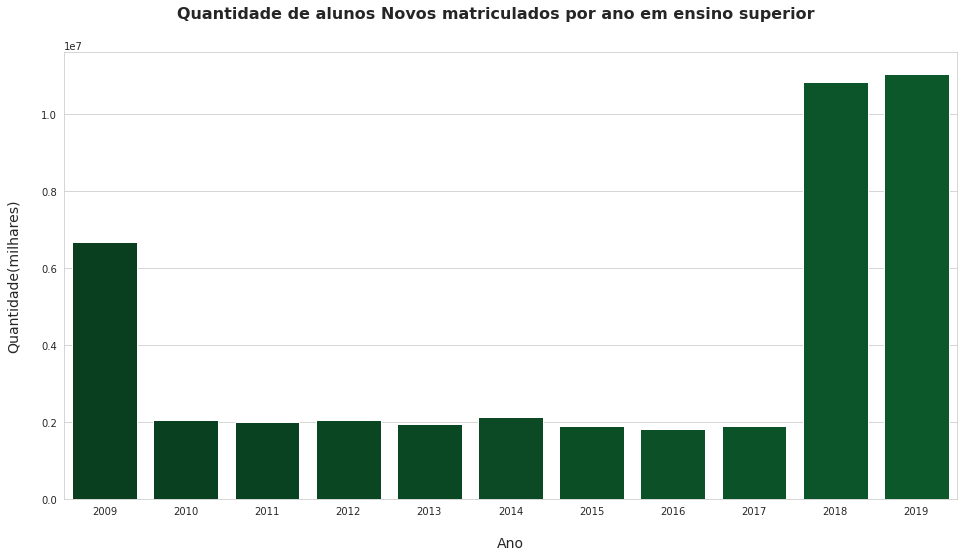

In [23]:
titulo = "Quantidade de alunos Novos matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(milhares)"
eixoX = anos
eixoY = serie_estudantes
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Vamos fazer o mesmo, mas agora para apenas população que se declara Negro("Cor" =2 )

In [24]:
data_negro =data[data["Cor/Raca"] == 2]
serie_negro =data_negro.groupby(["Ano"])["Cor/Raca"].count().values
serie_negro = serie_negro[1:]

In [25]:
# É importante notar que não existem nos dados que coletei numero de Negros em 2009( algum erro no calculo), logo pegaremos apenas dados de 2010 pra frente
anos_negro = anos[1:]


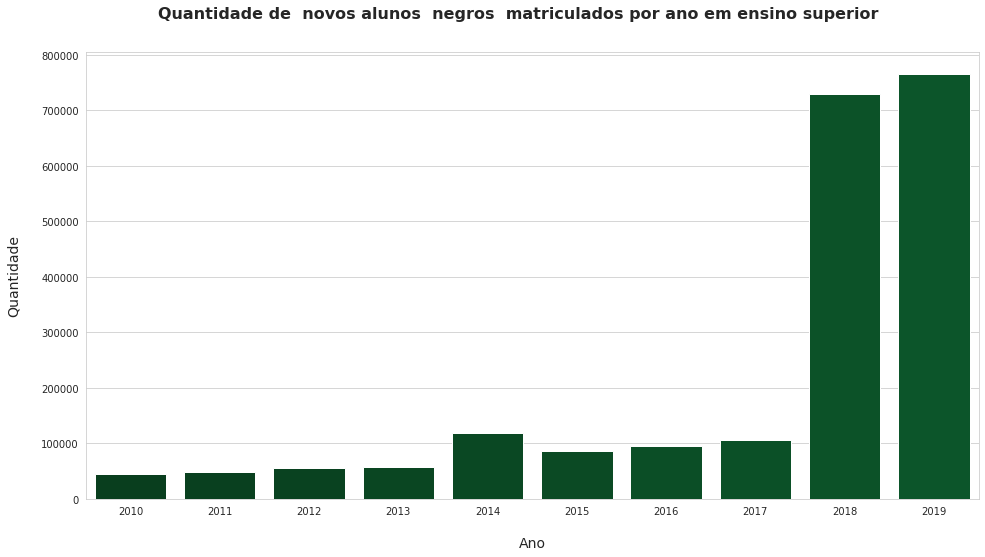

In [26]:
titulo = "Quantidade de  novos alunos  negros  matriculados por ano em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade"
eixoX = anos_negro
eixoY = serie_negro
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Olhando para estes gráficos não se tem dimensão da quantidade de negros em ensino superior em relação aos demais. Faremos um gráfico de proporção para demonstrar isto.

In [27]:
serie_proporcao = (serie_negro/serie_estudantes[1:])*100


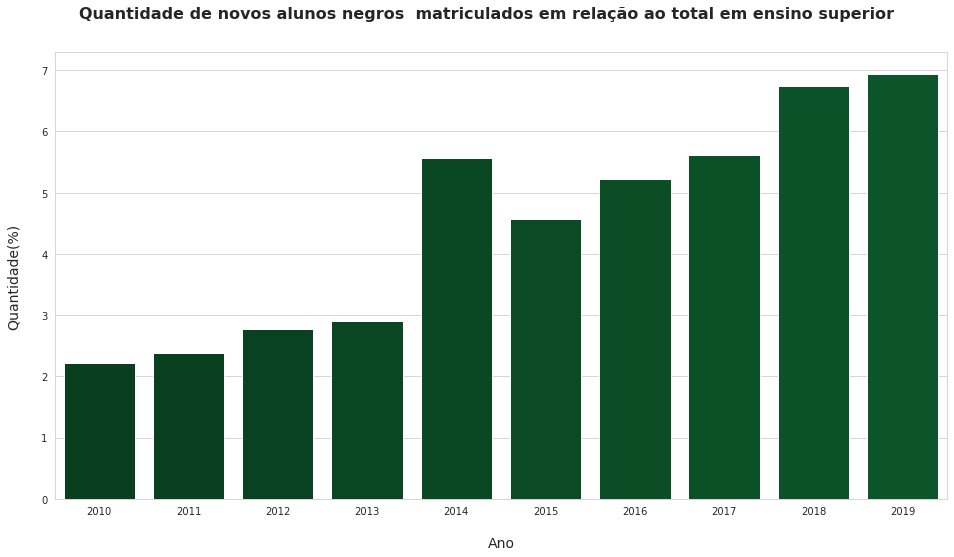

In [28]:
titulo = "Quantidade de novos alunos negros  matriculados em relação ao total em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = serie_proporcao
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Apenas 7% dos matriculados em 2019 são classificados negros, é um valor ínfimo em relação a sua representatividade na população. É importante notar que mesmo sendo uma porcentagem baixa, ela vem aumentando com o tempo, tendo um salto em 2014 para com os demais.Sera que a presença de cotas ajudou esse crecimento? 

## Análise cotas na população negra.

In [29]:
data_negro_cota = data_negro[data_negro.Cota_Racial == 1].groupby(["Ano"])["Cota_Racial"].count()
serie_cota = data_negro_cota.values
serie_cota = serie_cota[1:]

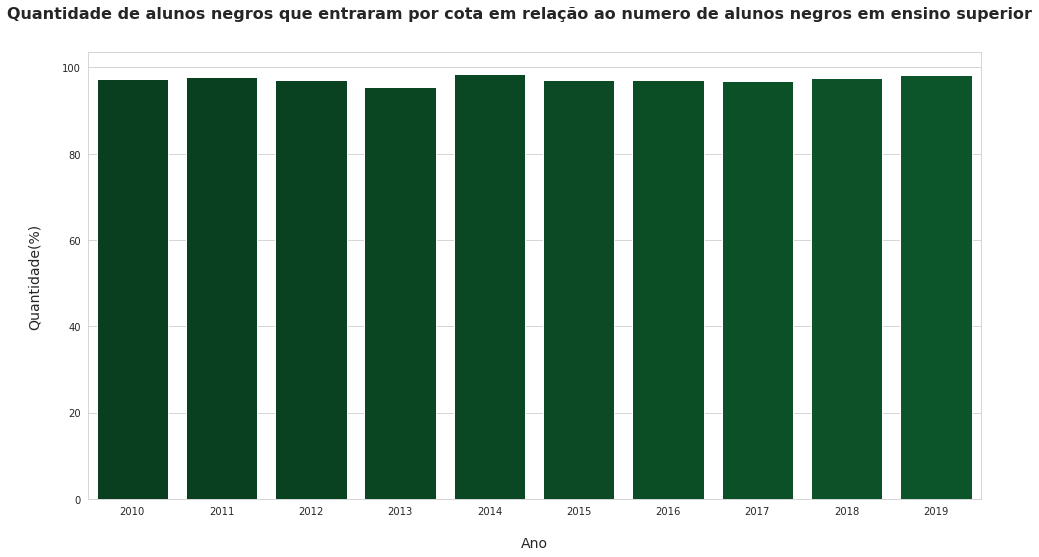

In [30]:

titulo = "Quantidade de alunos negros que entraram por cota em relação ao numero de alunos negros em ensino superior"
eixoXTitulo = "Ano"
eixoYTitulo = "Quantidade(%)"
eixoX = anos_negro
eixoY = (serie_cota/serie_negro)*100
plot_graph(titulo,eixoX,eixoY,eixoXTitulo,eixoYTitulo)

Todos os Anos, pelo menos 90% dos alunos negros entraram no ensino superior  atráves de cotas, o que implica que elas são de suma importância para a  presença de negros em escolas de ensino superior. 

##Análise de presença negras em universidades Públicas e privadas.

Outra análise se refere ao número de negros em universidades públicas e privadas. Vamos ver como se comporta

In [31]:
data_negro_publi = data_negro[(data_negro["Cat_Adm"].isin([1,2,3]))]
serie_negro_publi = data_negro_publi.groupby("Ano")["Cat_Adm"].count().values
            

In [32]:
serie_negro_priv_outros = serie_negro - serie_negro_publi[1:]


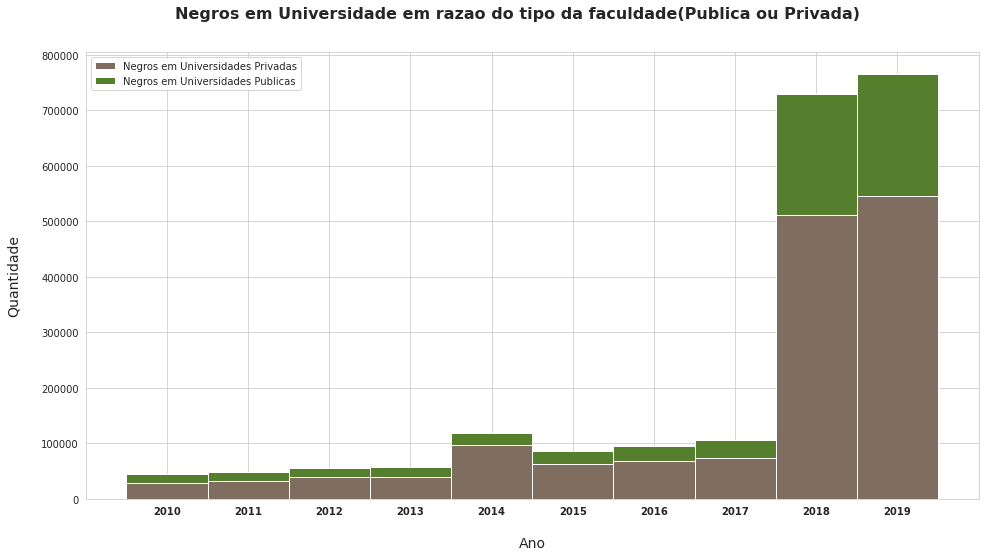

In [33]:
import numpy as np
# Values of each group
bars1 = serie_negro_priv_outros
bars2 = serie_negro_publi[1:]
 

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
fig.suptitle("Negros em Universidade em razao do tipo da faculdade(Publica ou Privada)", fontsize=16, fontweight='bold')
ax.set_xlabel("Ano",fontsize=14, labelpad=20)
ax.set_ylabel("Quantidade",fontsize=14, labelpad=20)

bars = np.add(bars1, bars2).tolist()

r = anos_negro
 
names = anos_negro
barWidth = 1
 
plt.bar(r, bars1, color='#7f6d5f', edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=barWidth)

 

plt.xticks(r, names, fontweight='bold')
ax.legend(["Negros em Universidades Privadas","Negros em Universidades Publicas"])
 
# Show graphic
plt.show()

Vemos aqui que a maioria de alunos negros matriculados está em universisade privadas e como vimos pelo grafico de cotas, vemos que mais de 90% dos alunos negros entraram com a ajuda de cotas, então é razoável concluir que as cotas raciais para negros é necessaria para o ingresso desta população no Ensino superior, principalmente em escolas públicas.


## Análise por Sexo.

##Analise Por Região/Estado

